In [1]:
import torch
import numpy as np  
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from utils import *

# 1. Downloading MNIST data

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
print(f"Number of training samples: {len(train_dataset)}")

test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
print(f"Number of test samples: {len(test_dataset)}")

Number of training samples: 60000
Number of test samples: 10000


# 3. Defining architecture that will be used for all participants

In [8]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.sequential = torch.nn.Sequential(
            torch.nn.Linear(28 * 28, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 10)
            )

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        return self.sequential(x)

    def backprop(self, grad_output):
        # Dummy backward pass
        grad_input = torch.autograd.grad(outputs=self.fc.weight, inputs=self.fc.weight, grad_outputs=grad_output)
        return grad_input

In [9]:
class Client():

    def __init__(self, model, dataloader, id):
        self.model = model
        self.dataloader = dataloader
        self.id = id
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
        self.loss_func = torch.nn.CrossEntropyLoss()
        self.n_params = len(self.get_params())

    def train(self):
        self.model.train()
        data, labels = next(iter(self.dataloader))
        
        outputs = self.model(data)
        loss = self.loss_func(outputs, labels)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def get_params(self):
        return torch.cat([p.view(-1,1) for p in self.model.parameters()]).detach()
    
    def get_grads(self):
        return torch.cat([p.grad.view(-1,1) for p in self.model.parameters()]).detach()
    
    def set_params(self, server):
        self.model.load_state_dict(server.model.state_dict())

    def __call__(self,x):
        return self.model(x)
    
    def __repr__ (self):
        return f"Client {self.id} with model\n\n {self.model}"

In [10]:
class Server():

    def __init__(self, model):
        self.model = model
        self.clients = []
        self.n_params = len(self.get_params())

    def get_params(self):
        return torch.cat([p.view(-1,1) for p in self.model.parameters()]).detach()
    
    def update_params_from_grad(self, grads, lr):
        j = 0
        for param in self.model.parameters():
            param.data -= lr*grads[j:j + param.numel(),:].mean(dim=1).view(param.shape)
            j += param.numel()

    def __call__(self, x):
        return self.model(x)

In [11]:
class FedNetwork():
    def __init__(self, clients, server):
        self.clients = clients
        self.server = server
        self.n_params = server.n_params
        self.n_clients = len(clients)
    
    def add_client(self, client):
        self.clients.append(client)
        self.n_clients += 1

    def initialize_clients(self):
        for client in self.clients:
            client.set_params(self.server)
    
    def train_clients(self):
            
        grads = torch.zeros(self.n_params, self.n_clients)
        params = torch.zeros(self.n_params, self.n_clients)

        # Optimizing clients for 1 batch
        for k, client in enumerate(self.clients):
            client.train()
            grads[:,k] = (client).get_grads().view(-1)
            params[:,k] = client.get_params().view(-1)
            
        return params, grads
    
    def update_client(self, grads, lr=0.1):
        self.server.update_params_from_grad(grads, lr)

In [12]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
print(f"Number of training samples: {len(train_dataset)}")

test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
print(f"Number of test samples: {len(test_dataset)}")

Number of training samples: 60000
Number of test samples: 10000


In [13]:
n_clients = 3

train_loaders = split_dataset(train_dataset, n_clients)

clients = [Client(model=Model(), dataloader=train_loaders[k], id=k+1) for k in range(n_clients)]
server = Server(model=Model())
net = FedNetwork(clients, server)

In [14]:
for i in tqdm(range(1_000)):

    # Initialize clients with server parameters
    net.initialize_clients()

    # Train clients and get gradients
    params, grads = net.train_clients()

    # Update server with gradients from clients
    net.update_client(grads, lr=0.1)

    # Evaluate server every 100 iterations
    if (i+1) % 100 == 0:
        print(f'Iteration {i+1} | Server eval: {evaluate(net.server.model, test_loader)}')

 11%|█         | 107/1000 [00:03<00:50, 17.71it/s]

Iteration 100 | Server eval: 0.8599


 21%|██        | 206/1000 [00:06<00:40, 19.82it/s]

Iteration 200 | Server eval: 0.8805


 31%|███       | 306/1000 [00:09<00:37, 18.64it/s]

Iteration 300 | Server eval: 0.896


 40%|████      | 405/1000 [00:12<00:31, 18.78it/s]

Iteration 400 | Server eval: 0.9034


 50%|█████     | 504/1000 [00:15<00:28, 17.69it/s]

Iteration 500 | Server eval: 0.9276


 60%|██████    | 604/1000 [00:18<00:26, 14.99it/s]

Iteration 600 | Server eval: 0.9338


 70%|███████   | 703/1000 [00:21<00:19, 15.05it/s]

Iteration 700 | Server eval: 0.9387


 81%|████████  | 808/1000 [00:24<00:09, 19.27it/s]

Iteration 800 | Server eval: 0.9433


 91%|█████████ | 906/1000 [00:27<00:05, 17.95it/s]

Iteration 900 | Server eval: 0.9447


100%|██████████| 1000/1000 [00:30<00:00, 32.94it/s]

Iteration 1000 | Server eval: 0.9507


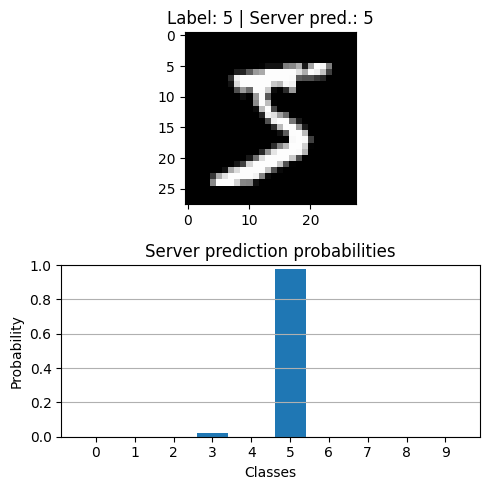

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(5, 5))

image = train_dataset[0][0].unsqueeze(0)  # Get a sample image
label = train_dataset[0][1]  # Get the corresponding
pred = net.server(image)  # Forward pass through the server model

ax[0].imshow(image.squeeze(), cmap='gray')
ax[0].set_title(f"Label: {label} | Server pred.: {pred.argmax(dim=1).item()}")

ax[1].bar(range(10), torch.nn.functional.softmax(pred.squeeze().detach(), dim=0).numpy())
ax[1].set_title("Server prediction probabilities")      
ax[1].set_xlabel("Classes")
ax[1].set_ylabel("Probability")
ax[1].set_ylim(0, 1)
ax[1].set_xticks(range(10))
ax[1].set_xticklabels(range(10))
ax[1].grid(axis='y')

plt.tight_layout()
plt.show()